---
title: "Unsupervised Learning"
author: "phonchi"
date: "12/05/2022"
format: 
  html:
    toc: true
    code-line-numbers: true
    code-tools: true
---

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math524/blob/master/static_files/presentations/Chapter_12_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math524/blob/master/static_files/presentations/Chapter_12_Lab.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>
<br/>

## Dimensional reduction

### Principal Components Analysis

In this lab, we perform PCA on the `USArrests` data set.
The rows of the data set contain the 50 states, in alphabetical order.

In [2]:
!pip install fancyimpute -qq
!pip install opentsne -qq
!pip install umap-learn -qq
!pip install git+https://github.com/dmuellner/fastcluster -qq
!pip install hdbscan -qq

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [51]:
import numpy as np
import pandas as pd
from itertools import cycle, islice

from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn import metrics 

from scipy import linalg
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

from fancyimpute import SoftImpute #pip install fancyimpute
import fastcluster as fc  #pip install git+https://github.com/dmuellner/fastcluster
from openTSNE import TSNE as oTSNE #pip install opentsne
import hdbscan #pip install hdbscan
import umap 

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-white')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [4]:
#from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#load the data 
USArrests = pd.read_csv('/content/drive/MyDrive/Lab/Data/USArrests.csv', index_col=0)
print(USArrests.shape)
USArrests.head()

(50, 4)


,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [7]:
USArrests.columns

Index(['Murder', 'Assault', 'UrbanPop', 'Rape'], dtype='object')

This data contains states of US
- Name  - name of the states
- Murder - number of arrests for murder per million pop. 
- Assault - number of arrests for assaults per million pop.
- Urbanpop - percentage of population living in urban area
- Rape - number of rape cases per million population

We first briefly examine the data. We notice that the variables have vastly different means.

In [8]:
USArrests.mean()

Murder        7.788
Assault     170.760
UrbanPop     65.540
Rape         21.232
dtype: float64

We see that there are on average three times as many rapes as murders, and more than eight times as many assaults as rapes.
We can also examine the variances of the four variables.

In [9]:
USArrests.var()

Murder        18.970465
Assault     6945.165714
UrbanPop     209.518776
Rape          87.729159
dtype: float64

Not surprisingly, the variables also have vastly different variances:
 the `UrbanPop` variable measures the percentage of the population in each state living in an urban area, which is not a comparable number to the number of rapes
in each state per 100,000 individuals. If we failed to scale the variables before performing PCA, then most of the principal components that we observed would be driven by the `Assault` variable, since it has by far the largest mean and variance. Thus, it is important to standardize the variables to have mean zero and standard deviation one before performing PCA.

In [10]:
# scaling the data 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(USArrests)

The `mean_` and `var_` components correspond to the means and variance of the variables that were used for scaling prior to implementing PCA.

In [11]:
scaler.mean_, scaler.var_

(array([  7.788, 170.76 ,  65.54 ,  21.232]),
 array([  18.591056, 6806.2624  ,  205.3284  ,   85.974576]))

Now, the mean is approximately 0, and std is approximately 1 for all the columns

In [12]:
X_scaled.mean(axis=0), X_scaled.var(axis=0)

(array([-7.10542736e-17,  1.38777878e-16, -4.39648318e-16,  8.59312621e-16]),
 array([1., 1., 1., 1.]))

In [13]:
# using pca to get principal components 
pca = PCA()
pca.fit(X_scaled)

PCA()

In [14]:
#loading vectors
pd.DataFrame(pca.components_,columns = USArrests.columns,index = ['PC1','PC2','PC3','PC4']).T

,PC1,PC2,PC3,PC4
Murder,0.535899,0.418181,-0.341233,0.649228
Assault,0.583184,0.187986,-0.268148,-0.743407
UrbanPop,0.278191,-0.872806,-0.378016,0.133878
Rape,0.543432,-0.167319,0.817778,0.089024


We see that there are four distinct principal components. This is to be expected because there are in general $\min(n-1,p)$ informative
principal components in a data set with $n$ observations and $p$ variables.

Using the `PCA()` function, we do not need to explicitly multiply the data by the principal component loading vectors  in order to obtain the principal component score vectors. Rather the $50 \times 4$ matrix `x` has as its columns the principal component score vectors. That is, the $k$th column is the $k$th principal component score vector.

In [15]:
# getting the points in principal components
X_reduced = pca.transform(X_scaled)
print(X_reduced.shape)
df = pd.DataFrame(X_reduced ,columns = ['PC1','PC2','PC3','PC4'])
df.head()

(50, 4)


,PC1,PC2,PC3,PC4
0,0.985566,1.133392,-0.444269,0.156267
1,1.950138,1.073213,2.040003,-0.438583
2,1.763164,-0.745957,0.054781,-0.834653
3,-0.141420,1.119797,0.114574,-0.182811
4,2.523980,-1.542934,0.598557,-0.341996


Text(0, 0.5, "2'nd Principal Component (Loading)")

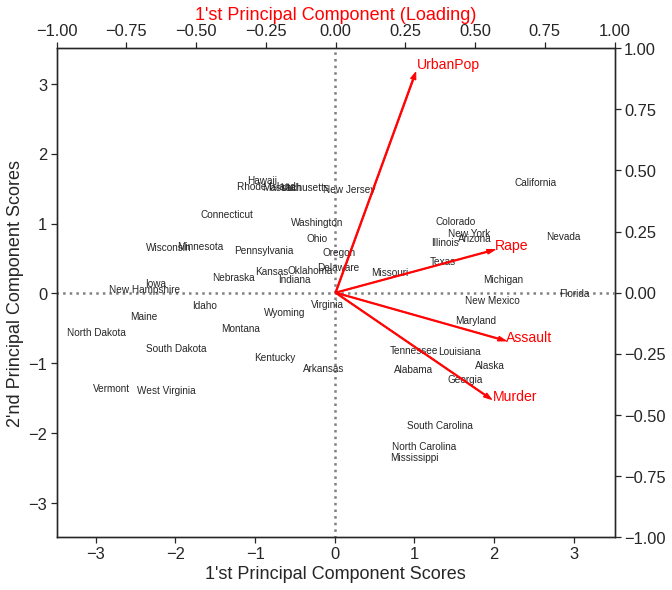

In [16]:
# biplot 
xvector = pca.components_[0] 
yvector = -pca.components_[1]

xs = X_reduced[:,0] 
ys = -X_reduced[:,1]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 9))

# First Plot : Principal Component Scores 'DF_USArrests_PCA_scores" 
x_min, x_max = xs.min() - 0.5, xs.max() + 0.5
y_min, y_max = xs.min() - 0.5, xs.max() + 0.5
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)


for i in range(len(xs)):
    # circles project documents (ie rows from csv) as points onto PC axes
    # plt.plot(xs[i], ys[i], 'bo')
    #plt.text(xs[i], ys[i], USArrests.index[i], color='black', alpha=0.8, size=10)
    ax1.annotate(USArrests.index[i], (xs[i], ys[i]), ha='center', size=10)

ax1.set_xlabel("1'st Principal Component Scores")
ax1.set_ylabel("2'nd Principal Component Scores")

# Plot reference lines
ax1.hlines(0,-3.5,3.5, linestyles='dotted', colors='grey')
ax1.vlines(0,-3.5,3.5, linestyles='dotted', colors='grey')

# Second Plot : Principal Component Loadings 'PCs' 
x_min, x_max = -1, 1          
y_min, y_max = -1, 1

ax2 = ax1.twinx().twiny()
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)



for i in range(len(xvector)):
    # arrows project features (ie columns from csv) as vectors onto PC axes
    #plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
    #          color='r', width=0.005, head_width=0.1)
    #plt.text(xvector[i]*max(xs)*1.1, yvector[i]*max(ys)*1.1,
    #         USArrests.columns[i], color='r', size=14)
    ax2.arrow(0, 0, xvector[i],  yvector[i], color='red', width=0.005, head_width=0.02)
    ax2.annotate(USArrests.columns[i], (xvector[i]*1.05, yvector[i]*1.05), color='red', size=14)  

    
ax2.set_xlabel("1'st Principal Component (Loading)", color='red')
ax2.set_ylabel("2'nd Principal Component (Loading)", color='red')

The `PCA` function also outputs the variance of each principal component. For instance, on the `USArrests` data set, we can access these standard deviations as follows:

In [17]:
# varianc explained by each pc's
pca.explained_variance_

array([2.53085875, 1.00996444, 0.36383998, 0.17696948])

To get the proportion of variance explained by each principal component, we simply use the following attribute:

In [18]:
pca.explained_variance_/np.var(X_reduced, ddof=1, axis=0).sum()

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

In [19]:
# variance explained ratio's 
pca.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

So, the first pc explaines 2.53 units of variance, which is around 62% of the total variance, the second pc expains 24.7 % of the variance in the data. We can plot the PVE explained by each component, as well as the cumulative PVE, as follows: 

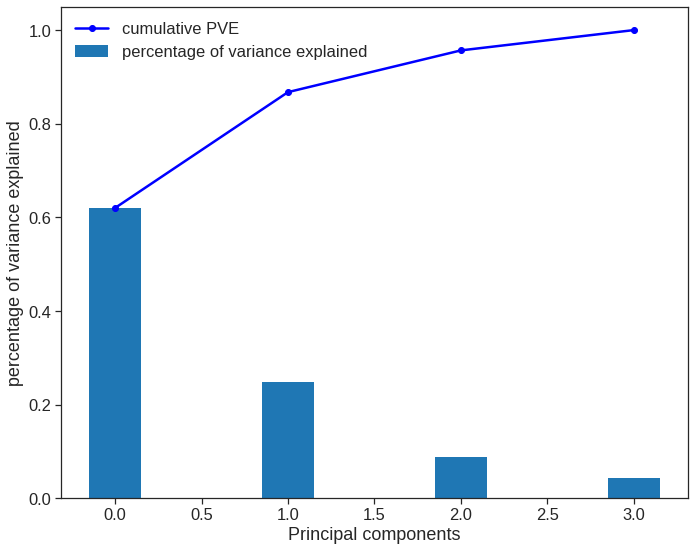

In [20]:
# Percentage of Variance Explained (PVE) by each PC:
plt.figure(figsize=(10, 8))
plt.ylim(0, 1.05)
index = np.arange(pca.components_.shape[0])
plt.bar(index, height=pca.explained_variance_ratio_ , width=0.3, align='center', 
        label='percentage of variance explained')
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'bo-', label='cumulative PVE')

plt.ylabel('percentage of variance explained')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

You can refer to [https://scikit-learn.org/stable/modules/decomposition.html#pca](https://scikit-learn.org/stable/modules/decomposition.html#pca) for more details

### Matrix Completion 
We now re-create the analysis carried out on the `USArrests` data in
Section 12.3. We turn the data frame into a
matrix, after centering and scaling each column to have mean zero and
variance one.

We saw in Section 12.2.2 that solving the optimization problem~(12.6)  on a centered data matrix $\bf X$ is
equivalent to computing the first $M$ principal components of the data. The 
(SVD)  is a general algorithm for solving (12.6).

In [21]:
u, d, v = linalg.svd(X_scaled, full_matrices=False)

The `svd()` function returns three components, `u`, `d`, and `v`. The matrix `v` is equivalent to the
loading matrix from principal components (up to an unimportant sign flip).

In [22]:
v.T

array([[-0.53589947,  0.41818087, -0.34123273,  0.6492278 ],
       [-0.58318363,  0.1879856 , -0.26814843, -0.74340748],
       [-0.27819087, -0.87280619, -0.37801579,  0.13387773],
       [-0.54343209, -0.16731864,  0.81777791,  0.08902432]])

The matrix `u` is equivalent to the matrix of *standardized* scores, and the standard deviations are in the vector `d`. We can recover the score vectors using the output of `svd()`.
They are identical to the score vectors output by `PCA()`.

In [23]:
m, n = X_scaled.shape
u[:,:n].dot(np.diag(d))
X_reduced

array([[ 9.85565885e-01,  1.13339238e+00, -4.44268788e-01,
         1.56267145e-01],
       [ 1.95013775e+00,  1.07321326e+00,  2.04000333e+00,
        -4.38583440e-01],
       [ 1.76316354e+00, -7.45956781e-01,  5.47808243e-02,
        -8.34652924e-01],
       [-1.41420290e-01,  1.11979678e+00,  1.14573692e-01,
        -1.82810896e-01],
       [ 2.52398013e+00, -1.54293399e+00,  5.98556799e-01,
        -3.41996478e-01],
       [ 1.51456286e+00, -9.87555085e-01,  1.09500699e+00,
         1.46488703e-03],
       [-1.35864746e+00, -1.08892789e+00, -6.43257569e-01,
        -1.18469414e-01],
       [ 4.77093091e-02, -3.25358925e-01, -7.18632942e-01,
        -8.81977637e-01],
       [ 3.01304227e+00,  3.92285133e-02, -5.76829492e-01,
        -9.62847520e-02],
       [ 1.63928304e+00,  1.27894240e+00, -3.42460080e-01,
         1.07679681e+00],
       [-9.12657146e-01, -1.57046001e+00,  5.07818939e-02,
         9.02806864e-01],
       [-1.63979985e+00,  2.10972917e-01,  2.59801342e-01,
      

We now omit 20 entries in the $50\times 4$ data matrix at random. We do so by first selecting 20 rows (states) at random, and then selecting one
of the four entries in each row at random. This ensures that every row has at least three observed values.


In [24]:
nomit = 20
np.random.seed(2)
ina = resample(range(50), n_samples = nomit, replace=False)
inb = resample(range(4), n_samples = nomit, replace=True)

In [25]:
ina

[36, 47, 28, 9, 13, 0, 44, 46, 39, 23, 24, 48, 17, 12, 27, 33, 16, 2, 25, 14]

In [26]:
Xna = X_scaled.copy()
Xna[ina, inb] = np.nan

Here, `ina` contains 20 integers from 1 to 50; this represents the states that are selected to contain missing values. And `inb` contains
20 integers from 1 to 4, representing the features that contain the missing values for each of the selected states. 

We now write some code to implement Algorithm 12.1. We first write a function that takes in a matrix, and returns an approximation to the matrix using the `svd()` function.
  This will be needed in Step 2 of Algorithm 12.1.

In [27]:
def SVD_approx(X, M=1):
    u, d, v = linalg.svd(X, full_matrices=False)
    #m, n = X.shape
    return u[:,:M].dot(np.diag(d[:M])).dot(v[:M,:])

To conduct Step 1 of the algorithm, we initialize `Xhat` --- this is $\tilde{\bf X}$ in Algorithm 12.1 --- by replacing
the missing values with the column means of the non-missing entries.

In [28]:
Xhat = Xna.copy()
xbar = np.nanmean(Xna, axis=0)
xbar

array([0.07184528, 0.02066806, 0.00883971, 0.01192302])

In [29]:
Xhat[ina, inb] = xbar[inb]

Before we begin Step 2, we set ourselves up to measure the progress of our iterations:

In [30]:
thresh = 1e-7
rel_err = 1
itera = 0
ismiss = np.isnan(Xna)
XX = Xna-xbar
mssold = np.mean((XX[~ismiss])**2)
mss0 = np.mean(Xna[~ismiss]**2)

In [31]:
mssold, mss0

(1.0160715803147764, 1.0175207163820559)

Here  `ismiss` is a new logical matrix with the same dimensions as `Xna`; a given element equals `True` if the corresponding matrix element is missing. This is useful
because it allows us to access both the missing and non-missing entries. We store the mean of the squared non-missing elements in `mss0`.
We store the mean squared error  of the non-missing elements  of the old version of `Xhat` in `mssold`. We plan to store the mean squared error of the non-missing elements of the current version of `Xhat` in `mss`, and will then  iterate Step 2 of Algorithm 12.1 until the *relative error*, defined as 
`(mssold - mss) / mss0`, falls below `thresh = 1e-7`. ( *Algorithm 12.1  tells us to iterate Step 2 until (12.14) is no longer decreasing. Determining whether (12.14)  is decreasing requires us only to keep track of `mssold - mss`. However, in practice, we keep track of `(mssold - mss) / mss0` instead: this makes it so that the number of iterations required for Algorithm 12.1 to converge does not depend on whether we multiplied the raw data $\bf X$ by a constant factor.* )

In Step 2(a) of Algorithm 12.1, we approximate `Xhat` using `SVD_approx`; we call this `Xapp`.   In Step 2(b), we  use `Xapp`  to update the estimates for elements in `Xhat` that are missing in `Xna`. Finally, in Step 2(c), we compute the relative error. These three steps are contained in this `while()` loop:

In [32]:
while rel_err > thresh:
    itera = itera + 1
    # Step 2(a)
    Xapp  = SVD_approx(Xhat, M=1)
    # Step 2(b)
    Xhat[ismiss] = Xapp[ismiss]
    # Step 2(c)
    XX = Xna-Xapp
    mss = np.mean((XX[~ismiss])**2)
    rel_err = (mssold - mss) / mss0
    mssold = mss
    print("Iter: %d "%itera)
    print("MSS: %f "%mss)
    print("Rel. Err:%f \n"%rel_err)

Iter: 1 
MSS: 0.414600 
Rel. Err:0.591115 

Iter: 2 
MSS: 0.398214 
Rel. Err:0.016104 

Iter: 3 
MSS: 0.396375 
Rel. Err:0.001807 

Iter: 4 
MSS: 0.396105 
Rel. Err:0.000265 

Iter: 5 
MSS: 0.396051 
Rel. Err:0.000054 

Iter: 6 
MSS: 0.396037 
Rel. Err:0.000014 

Iter: 7 
MSS: 0.396033 
Rel. Err:0.000004 

Iter: 8 
MSS: 0.396032 
Rel. Err:0.000001 

Iter: 9 
MSS: 0.396032 
Rel. Err:0.000000 

Iter: 10 
MSS: 0.396031 
Rel. Err:0.000000 



We see that after eight iterations, the relative error has fallen below `thresh = 1e-7`, and so the algorithm terminates. When this happens, the mean squared error of the non-missing elements equals $0.396$.

Finally, we compute the correlation between the 20 imputed values and the actual values:

In [33]:
np.corrcoef(Xhat[ismiss], X_scaled[ismiss])

array([[1.        , 0.80681102],
       [0.80681102, 1.        ]])

In this lab, we implemented Algorithm 12.1 ourselves for didactic purposes. In practice, if you wishes to apply matrix completion to your
data, you can use the [https://github.com/iskandr/fancyimpute](https://github.com/iskandr/fancyimpute) package, which provides a very eﬃcient implementation of a generalization of this algorithm.

In [34]:
Xhat2 = Xna.copy()
X_filled = SoftImpute(max_rank=1).fit_transform(Xhat2)

[SoftImpute] Max Singular Value of X_init = 10.088074
[SoftImpute] Iter 1: observed MAE=0.477063 rank=1
[SoftImpute] Iter 2: observed MAE=0.463440 rank=1
[SoftImpute] Iter 3: observed MAE=0.460874 rank=1
[SoftImpute] Iter 4: observed MAE=0.460157 rank=1
[SoftImpute] Iter 5: observed MAE=0.459960 rank=1
[SoftImpute] Iter 6: observed MAE=0.459916 rank=1
[SoftImpute] Iter 7: observed MAE=0.459900 rank=1
[SoftImpute] Iter 8: observed MAE=0.459894 rank=1
[SoftImpute] Iter 9: observed MAE=0.459891 rank=1
[SoftImpute] Stopped after iteration 9 for lambda=0.201761


In [35]:
np.corrcoef(X_filled[ismiss], X_scaled[ismiss])

array([[1.        , 0.80736346],
       [0.80736346, 1.        ]])

### t-SNE

In [36]:
digits = load_digits()

In [37]:
X = digits.images.reshape(-1, digits.images.shape[1]*digits.images.shape[2]) #vectorize
X.shape

(1797, 64)

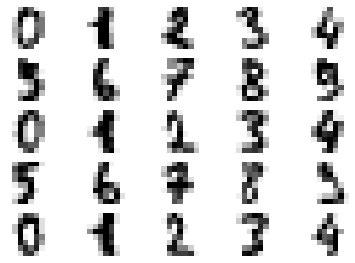

In [38]:
fig, ax_array = plt.subplots(5, 5)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray_r')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

In [39]:
tsne = TSNE(
    n_components=2, perplexity=30, init="pca", learning_rate="auto", random_state=0, verbose=True
)

In [40]:
embedding = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.001s...
[t-SNE] Computed neighbors for 1797 samples in 0.230s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 11.585657


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.981926
[t-SNE] KL divergence after 1000 iterations: 0.780030


Text(0.5, 1.0, 'tSNE of the Digits dataset')

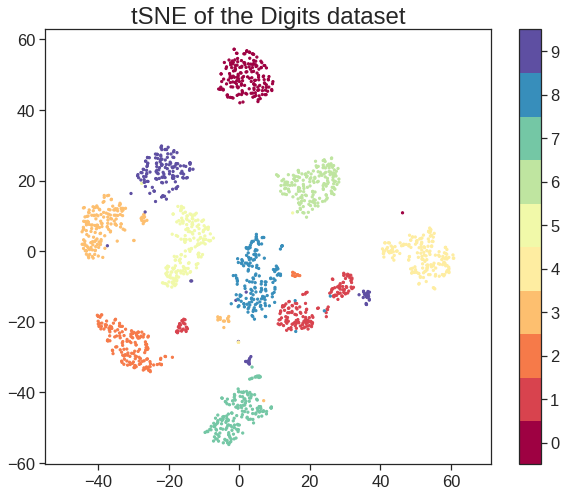

In [41]:
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('tSNE of the Digits dataset', fontsize=24)

openTSNE provides fast implementation and more optimization related to t-SNE, see [https://opentsne.readthedocs.io/en/latest/](https://opentsne.readthedocs.io/en/latest/) for more details.

In [42]:
otsne = oTSNE(
    n_components=2,
    perplexity=30,
    initialization='pca', 
    n_jobs=2,
    random_state=0,
    negative_gradient_method='auto', 
    verbose=True,
)

In [43]:
embedding = otsne.fit(X)

--------------------------------------------------------------------------------
TSNE(n_jobs=2, random_state=0, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 1.32 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.29 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 3.1044, 50 iterations in 0.7805 sec
Iteration  100, KL divergence 2.7275, 50 iterations in 0.4949 sec
Iteration  150, KL divergence 2.6611, 50 iterations in 0.6111 sec
Iteration  200, KL divergence 2.6358, 50 iterations in 0.5653 sec
Iteration  250, KL divergence 2.6226, 50 iterations in 0.7305 sec
   --> Time elapsed: 3.19 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 it

Text(0.5, 1.0, 'tSNE of the Digits dataset')

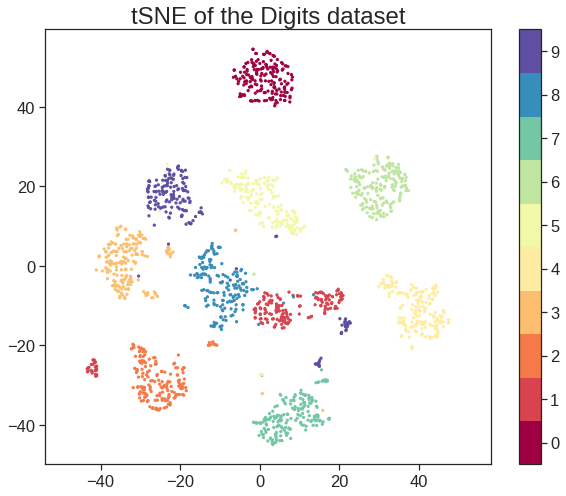

In [44]:
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('tSNE of the Digits dataset', fontsize=24)

### UMAP

UMAP is useful for generating visualisations, but if you want to make use of UMAP more generally for machine learning tasks it is important to be be able to train a model and then later pass new data to the model and have it transform that data into the learned space. For example if we use UMAP to learn a latent space and then train a classifier on data transformed into the latent space then the classifier is only useful for prediction if we can transform data for which we want a prediction into the latent space the classifier uses. 

In [47]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, stratify=digits.target, random_state=42)

Now to get a benchmark idea of what we are looking at let’s train a couple of different classifiers and then see how well they score on the test set. For this example let’s try a support vector classifier and a KNN classifier.

In [52]:
svc = SVC(gamma='auto').fit(X_train, y_train)
knn = KNeighborsClassifier().fit(X_train, y_train)
svc.score(X_test, y_test), knn.score(X_test, y_test)

(0.62, 0.9844444444444445)

The goal now is to make use of UMAP as a preprocessing step that one could potentially fit into a pipeline. 

In [53]:
trans = umap.UMAP(n_neighbors=5, random_state=42).fit(X_train)

Text(0.5, 1.0, 'Umap of the Digits dataset')

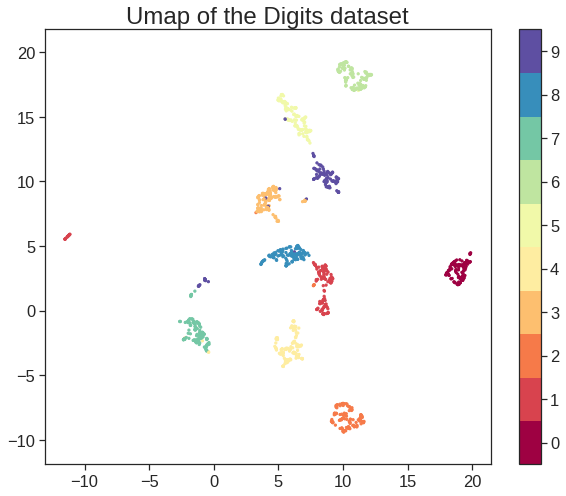

In [54]:
plt.figure(figsize=(10, 8))
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], c=y_train, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Umap of the Digits dataset', fontsize=24)

This looks very promising! Most of the classes got very cleanly separated, and that gives us some hope that it could help with classifier performance. We can now train some new models (again an SVC and a KNN classifier) on the embedded training data. This looks exactly as before but now we pass it the embedded data. 

In [55]:
svc = SVC(gamma='auto').fit(trans.embedding_, y_train)
knn = KNeighborsClassifier().fit(trans.embedding_, y_train)

In [56]:
test_embedding = trans.transform(X_test)

The next important question is what the transform did to our test data. In principle we have a new two dimensional representation of the test-set, and ideally this should be based on the existing embedding of the training set

Text(0.5, 1.0, 'Umap of the Digits dataset')

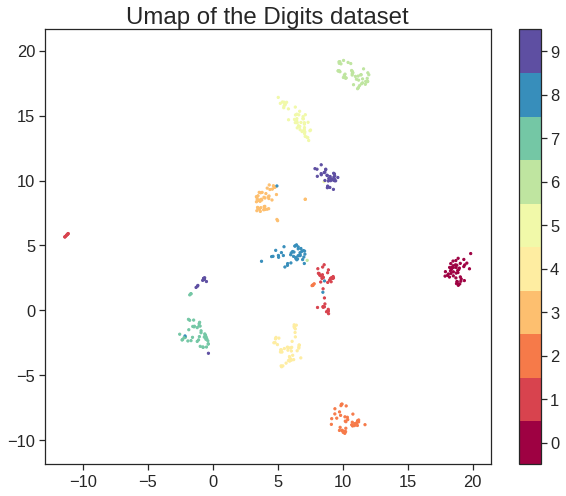

In [57]:
plt.figure(figsize=(10, 8))
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c=y_test, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Umap of the Digits dataset', fontsize=24)

The results look like what we should expect; the test data has been embedded into two dimensions in exactly the locations we should expect (by class) given the embedding of the training data visualised above. This means we can now try out models that were trained on the embedded training data by handing them the newly transformed test set.

In [58]:
svc.score(trans.transform(X_test), y_test), knn.score(trans.transform(X_test), y_test)

(0.9822222222222222, 0.9822222222222222)

The results are pretty good. While the accuracy of the KNN classifier did not improve there was not a lot of scope for improvement given the data. On the other hand the SVC has improved to have equal accuracy to the KNN classifier!

For more interesting datasets the larger dimensional embedding might have been a significant gain – it is certainly worth exploring as one of the parameters in a grid search across a pipeline that includes UMAP.



## Clustering

### $K$-Means Clustering

You can refer to [https://scikit-learn.org/stable/modules/clustering.html](https://scikit-learn.org/stable/modules/clustering.html) for more details

The function `kmeans()` performs $K$-means clustering in `Python`.  We begin with a simple simulated example in which there
truly are two clusters in the data: the first 25 observations have a mean shift relative to the next 25 observations.

In [59]:
# set seed 
np.random.seed(2)
X = np.random.normal(size = (50,2))
X[:25,0] += 3 
X[:25,1] -= 4

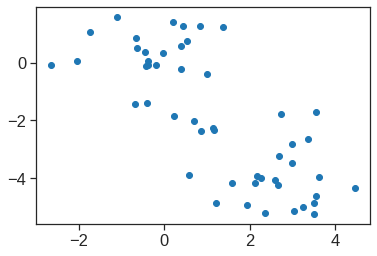

In [60]:
plt.scatter(X[:,0],X[:,1])

We now perform $K$-means clustering with $K=2$.

In [61]:
kmeans = KMeans(n_clusters = 2, n_init=20, random_state=1)
kmeans.fit(X)

KMeans(n_clusters=2, n_init=20, random_state=1)

The cluster assignments of the 50 observations are listed as below:

In [62]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0], dtype=int32)

The $K$-means clustering nearly perfectly separated the observations into two clusters even though we did not supply any group information to `kmeans()`. We can plot the data, with each observation
colored according to its cluster assignment.

Text(0, 0.5, 'X1')

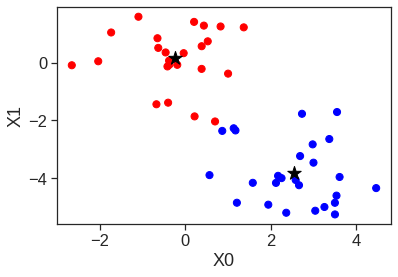

In [63]:
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, s=50, cmap=plt.cm.bwr)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],marker = '*', c='black', s=200, alpha=1)
plt.xlabel('X0')
plt.ylabel('X1')

In [64]:
np.bincount(kmeans.labels_)
# 26 obs are classified in cluster 1, and 24 in cluster 2

array([26, 24])

Here the observations can be easily plotted because they are two-dimensional. If there were more than two variables then we could instead perform PCA and plot the first two principal components score vectors.

In this example, we knew that there really were two clusters because we generated the data. However, for real data, in general we do not know the true number of clusters. We could instead have performed $K$-means clustering on this example with $K=3$.

Text(0, 0.5, 'X1')

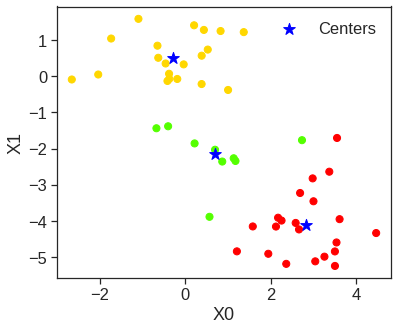

In [65]:
kmean2 = KMeans(n_clusters=3, n_init=20, random_state=1)
kmean2.fit(X)

plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], s=50, c=kmean2.labels_, cmap=plt.cm.prism) 
plt.scatter(kmean2.cluster_centers_[:, 0], kmean2.cluster_centers_[:, 1], marker='*', s=150,
            color='blue', label='Centers')
plt.legend(loc='best')
plt.xlabel('X0')
plt.ylabel('X1')

When $K=3$, $K$-means clustering  splits up the two clusters.

To run the `kmeans()` function in `Python` with multiple initial cluster assignments, we use the
`n_init` argument. If a value of `n_init` greater than one is used, then $K$-means clustering will be performed using
multiple random assignments in Step~1 of Algorithm 12.2, and the `kmeans()` function will report only the best results. Here we compare using `n_init = 1` to `n_init = 20`.

In [66]:
kmeans3 = KMeans(n_clusters=3, n_init=1, random_state=0)
kmeans3.fit(X)
kmeans4 = KMeans(n_clusters=3,  n_init=20, random_state=0)
kmeans4.fit(X)

print('inertia with n_init=1:', kmeans3.inertia_)
print('inertia with n_init=20:', kmeans4.inertia_)

inertia with n_init=1: 69.42547524486459
inertia with n_init=20: 68.97379200939723


Note that `kmeans.inertia_` is the sum of squared distances of samples to their closest cluster center which we seek to minimize by performing $K$-means clustering.
We *strongly* recommend always running $K$-means clustering with a large value of `n_init`, such as 20 or 50, since otherwise an undesirable local optimum may be obtained.

When performing $K$-means clustering, in addition to using multiple initial cluster assignments, it is also  important to set a random seed using the `random_state`. This way, the
initial cluster assignments in Step~1 can be replicated, and the $K$-means output will be fully reproducible.

### Hierarchical Clustering

The `AgglomerativeClustering()` function implements  hierarchical clustering in `Python`. In the following example we use the data from the previous lab to
 plot the hierarchical clustering dendrogram using complete, single, and average linkage clustering, with  Euclidean distance as the dissimilarity measure.
We begin by clustering observations using complete linkage. 

In [67]:
hclust = AgglomerativeClustering(n_clusters=2, linkage='complete', compute_distances=True)    
hclust.fit(X)
hclust.labels_

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

We could just as easily perform hierarchical clustering with average or single linkage instead:

In [68]:
hclust = AgglomerativeClustering(n_clusters=2, linkage='average', compute_distances=True)    
hclust.fit(X)
hclust.labels_

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [69]:
hclust = AgglomerativeClustering(n_clusters=2, linkage='single', compute_distances=True)    
hclust.fit(X)
hclust.labels_

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

We can now plot the dendrograms obtained using the custom function. The numbers at the bottom of the plot identify each observation.

Text(0.5, 0, 'Number of points in node (or index of point if no parenthesis).')

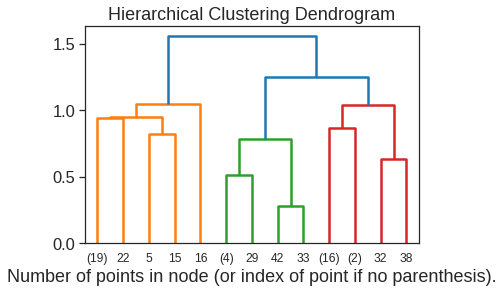

In [70]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(hclust, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")

You can also perform clustering using Scipy, see [https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html) for more details.

In [71]:
hc_complete = linkage(X, method='complete')
hc_average = linkage(X, method='average')
hc_single = linkage(X, method='single')

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, 'Single Linkage')

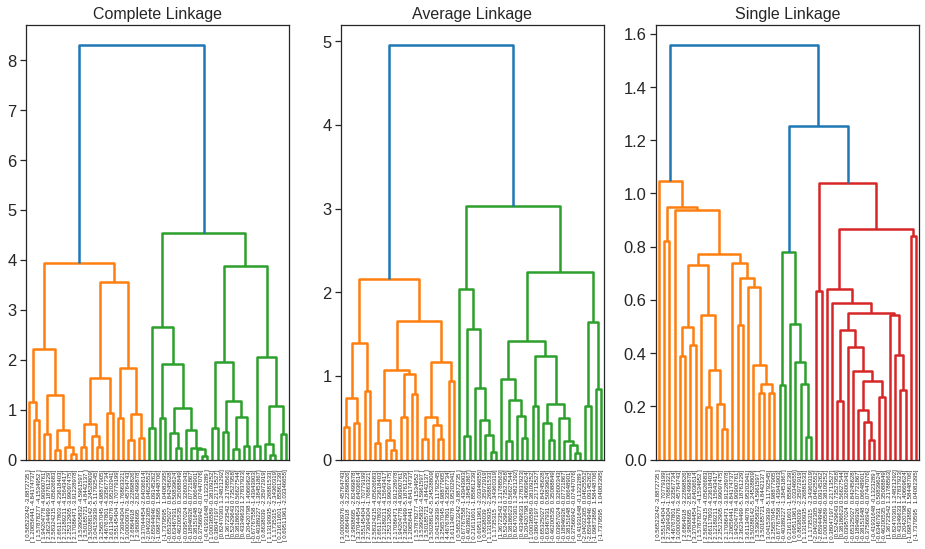

In [72]:
f, axes = plt.subplots(1, 3, sharex=False, sharey=False)

f.set_figheight(8)
f.set_figwidth(16)

dendrogram(hc_complete,
           labels=X,
           leaf_rotation=90,
           leaf_font_size=6,
           ax=axes[0])

dendrogram(hc_average,
           labels=X, # coordinates
           leaf_rotation=90,
           leaf_font_size=6,
           ax=axes[1])

dendrogram(hc_single,
           labels=X,
           leaf_rotation=90,
           leaf_font_size=6,
           ax=axes[2])

axes[0].set_title('Complete Linkage', size=16)
axes[1].set_title('Average Linkage', size=16)
axes[2].set_title('Single Linkage', size=16)

To determine the cluster labels for each observation associated with a given cut of the dendrogram, we can use the `cutree()` function:
The second argument to `cutree()` is the number of clusters we wish to obtain.
For this data, complete and average linkage generally separate the observations into their correct groups. However, single linkage does not.

In [73]:
cut_tree(hc_complete, n_clusters=2, height=None).ravel()

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [74]:
cut_tree(hc_average, 2).ravel()

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [75]:
cut_tree(hc_single, 2).ravel()

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [76]:
cut_tree(hc_single, 3).ravel()

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 1])

To scale the variables before performing hierarchical clustering of the observations:

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, 'Hierarchical Clustering with Scaled Features')

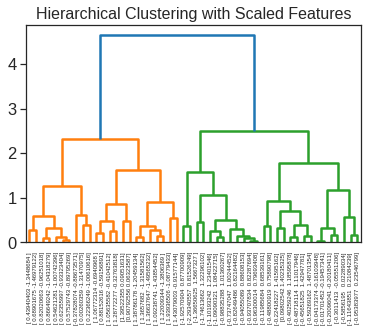

In [77]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dendrogram(linkage(X_scaled, method='complete'),
           labels=X_scaled,
           leaf_rotation=90,
           leaf_font_size=6)

plt.title('Hierarchical Clustering with Scaled Features', size=16)

Correlation-based distance can be computed using the `pdist()` function, which converts an arbitrary square symmetric matrix into a form that the `scipy` recognizes as a distance matrix. However, this only makes sense for data with at least three features since the absolute correlation between any two observations with measurements on two features is always 1. Hence, we will cluster a three-dimensional data set. This data set does not contain any true clusters.

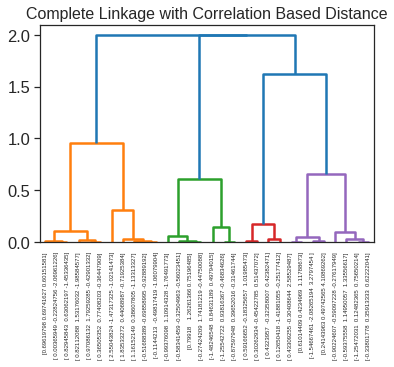

In [78]:
X = np.random.normal(size=30*3).reshape(30, 3)

# scipy linkage takes care of the distance function pdist
dendrogram(linkage(X, method='complete', metric='correlation'),
           labels=X,
           leaf_rotation=90,
           leaf_font_size=6)

plt.title('Complete Linkage with Correlation Based Distance', size=16);

You can get a more efficient implementation at [http://danifold.net/fastcluster.html](http://danifold.net/fastcluster.html). The usuage is the same as Scipy.

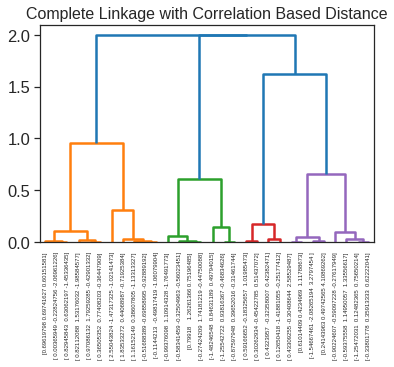

In [79]:
lk = fc.linkage(X, method='complete', metric='correlation', preserve_input=True)
dendrogram(lk,
           labels=X,
           leaf_rotation=90,
           leaf_font_size=6)

plt.title('Complete Linkage with Correlation Based Distance', size=16);

### DBSCAN

In [80]:
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)

For more clustering performance measure see [https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation).

In [81]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)

Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916


Text(0.5, 1.0, 'Estimated number of clusters: 3')

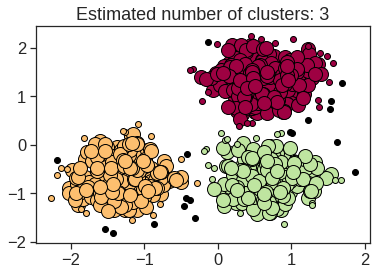

In [82]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)

The DBSCAN, however, is quite sensitive to the hypeparameter

In [83]:
# Generate sample data
centers = [[0, 0], [5, 5]]
X, labels_true = make_blobs(
    n_samples=500, centers=centers, cluster_std=[2.0,0.5], random_state=0
)


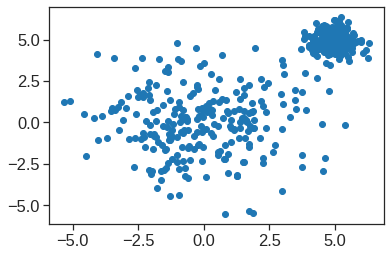

In [84]:
plt.scatter(X[:,0],X[:,1])

In [85]:
epss = [2,2,3,3]
min_sampless = [50,100,50,100]

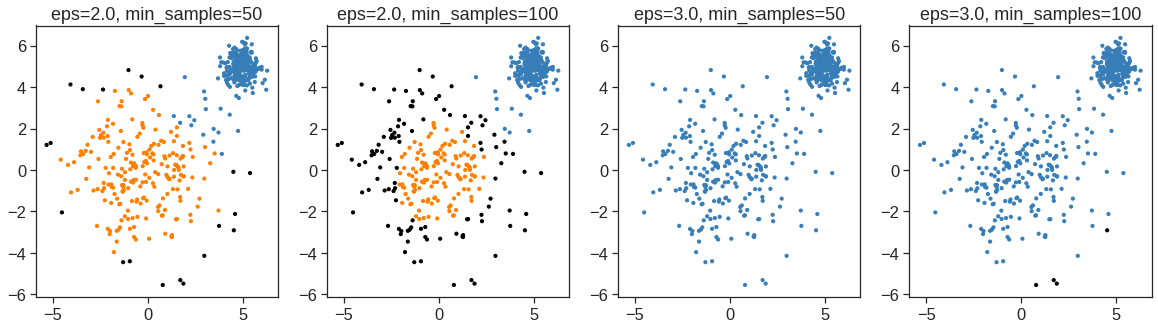

In [86]:
f, axes = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(20,5))

for i in range(4):
  db = DBSCAN(eps=epss[i], min_samples=min_sampless[i]).fit(X)
  y_pred = db.labels_.astype(int)
  colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
  # add black color for outliers (if any)
  colors = np.append(colors, ["#000000"])
  axes[i].scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

  axes[i].set_title("eps=%.1f, min_samples=%d" % (epss[i],min_sampless[i]))

You can try to use HDBSCAN instead. For more information, please refer to [https://hdbscan.readthedocs.io/en/latest/index.html](https://hdbscan.readthedocs.io/en/latest/index.html).

In [87]:
min_cluster_sizes = [5,10,30,50]

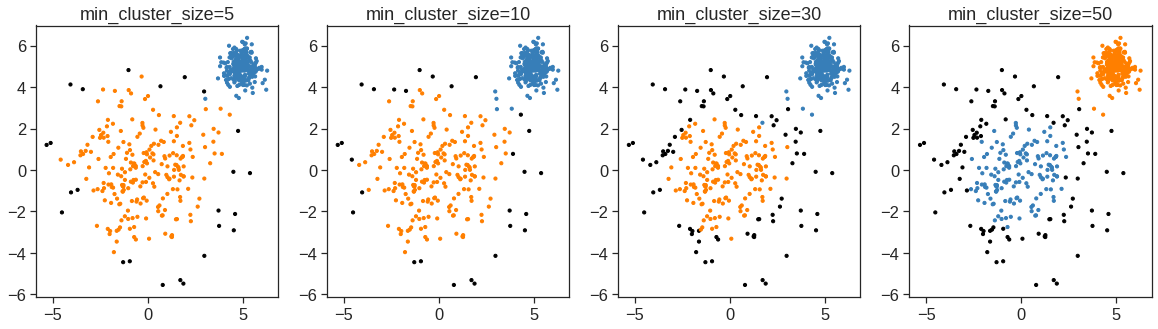

In [88]:
f, axes = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(20,5))

for i in range(4):
  db = hdbscan.HDBSCAN(min_cluster_size=min_cluster_sizes[i]).fit(X)
  y_pred = db.labels_.astype(int)
  colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
  # add black color for outliers (if any)
  colors = np.append(colors, ["#000000"])
  axes[i].scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
  axes[i].set_title("min_cluster_size=%d" % (min_cluster_sizes[i]))

## NCI60 Data Example

Unsupervised techniques are often used in the analysis of genomic data. In particular, PCA and hierarchical clustering are popular tools.
 We  illustrate these techniques on the `NCI` cancer cell line microarray data, which consists of $6{,}830$ gene expression measurements on $64$ cancer cell lines.

In [89]:
NCI60_labs = pd.read_csv("/content/drive/MyDrive/Lab/Data/NCI60_labs.csv", index_col=0)
NCI60_data = pd.read_csv("/content/drive/MyDrive/Lab/Data/NCI60_data.csv", index_col=0)

NCI60_data.head()

,1,2,3,4,5,6,7,8,9,10,...,6821,6822,6823,6824,6825,6826,6827,6828,6829,6830
V1,0.300000,1.180000,0.550000,1.140000,-0.265000,-7.000000e-02,0.350000,-0.315000,-0.450000,-0.654980,...,-0.990020,0.000000,0.030000,-0.175000,0.629981,-0.030000,0.000000,0.280000,-0.340000,-1.930000
V2,0.679961,1.289961,0.169961,0.379961,0.464961,5.799610e-01,0.699961,0.724961,-0.040039,-0.285019,...,-0.270058,-0.300039,-0.250039,-0.535039,0.109941,-0.860039,-1.250049,-0.770039,-0.390039,-2.000039
V3,0.940000,-0.040000,-0.170000,-0.040000,-0.605000,0.000000e+00,0.090000,0.645000,0.430000,0.475019,...,0.319981,0.120000,-0.740000,-0.595000,-0.270020,-0.150000,0.000000,-0.120000,-0.410000,0.000000
V4,0.280000,-0.310000,0.680000,-0.810000,0.625000,-1.387779e-17,0.170000,0.245000,0.020000,0.095019,...,-1.240020,-0.110000,-0.160000,0.095000,-0.350019,-0.300000,-1.150010,1.090000,-0.260000,-1.100000
V5,0.485000,-0.465000,0.395000,0.905000,0.200000,-5.000000e-03,0.085000,0.110000,0.235000,1.490019,...,0.554980,-0.775000,-0.515000,-0.320000,0.634980,0.605000,0.000000,0.745000,0.425000,0.145000


Each cell line is labeled with a cancer type, given in `NCI60_labs`. We do not make use of the cancer types in performing PCA and clustering, as these are unsupervised techniques. But
after performing PCA and clustering, we will check to see the extent to which these cancer types agree with the results of these unsupervised techniques.

The data has $64$ rows and $6{,}830$ columns.

In [90]:
NCI60_labs.value_counts()

x          
NSCLC          9
RENAL          9
MELANOMA       8
BREAST         7
COLON          7
LEUKEMIA       6
OVARIAN        6
CNS            5
PROSTATE       2
K562A-repro    1
K562B-repro    1
MCF7A-repro    1
MCF7D-repro    1
UNKNOWN        1
dtype: int64

### PCA on the NCI60 Data

We first perform PCA on the data after scaling the variables (genes) to have standard deviation one, although one could reasonably argue that it is better not to scale the genes.

In [91]:
scaler = StandardScaler()
NCI60_scaled = scaler.fit_transform(NCI60_data)

pca = PCA()
pca.fit(NCI60_scaled)

PCA()

We now  plot the first few principal component score vectors, in order to visualize the data. The observations (cell lines) corresponding to a given cancer type will be plotted in the same color, so that we can see to what extent the observations within a cancer type are similar to each other. We first create a simple function that assigns a distinct color to each element of a numeric vector.
The function will be used to assign a  color to each of the $64$ cell lines, based on the cancer type to which it corresponds.

In [92]:
X_reduced = pca.transform(NCI60_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0, 0.5, 'Z3')

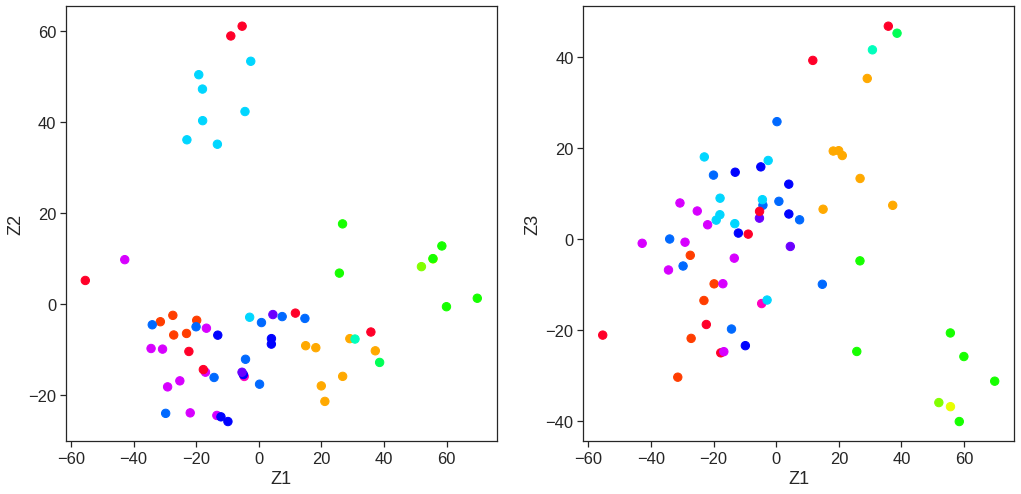

In [93]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17, 8))

Z1 = X_reduced[:, 0]    
Z2 = X_reduced[:, 1]   
Z3 = X_reduced[:, 2]    

# print(list(le.fit_transform(nci_labs.x)))
# list(enumerate(le.classes_))
le = LabelEncoder()
ax1.scatter(Z1, Z2, s=70, c=le.fit_transform(NCI60_labs), cmap=plt.cm.gist_rainbow)     
ax1.set_xlabel('Z1', size=18)
ax1.set_ylabel('Z2', size=18)

ax2.scatter(Z1, Z3, s=70, c=le.fit_transform(NCI60_labs), cmap=plt.cm.gist_rainbow) 
ax2.set_xlabel('Z1', size=18)
ax2.set_ylabel('Z3', size=18)

The resulting  plots are shown in Figure 12.17. On the whole, cell lines corresponding to a single cancer type do tend to have similar values on the first few
principal component score vectors. This indicates that cell lines from the same cancer type tend to have pretty similar gene expression levels.

We can obtain a summary of the proportion of variance explained (PVE) of the first few principal components:

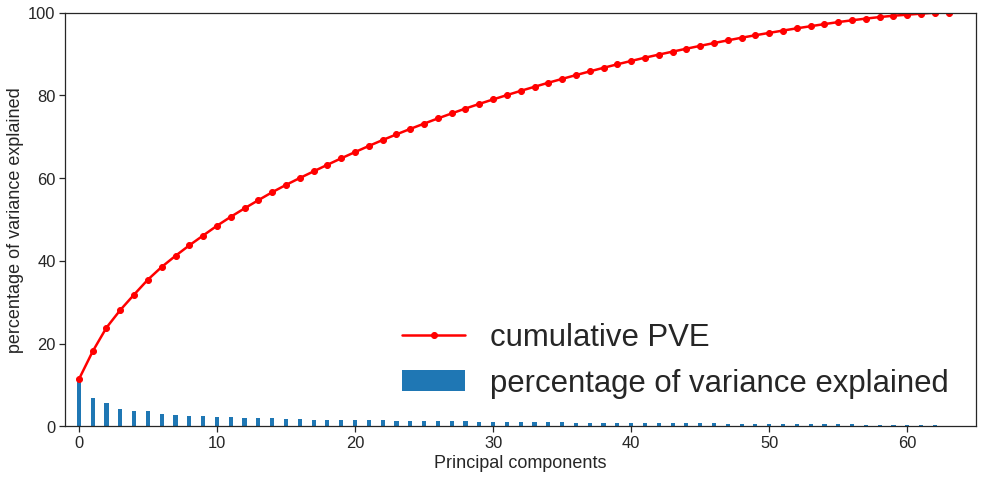

In [94]:
# Percentage of Variance Explained by each PC:
plt.figure(figsize=(14, 7))
plt.ylim(0, 100)
plt.xlim(-1, 65)
index = np.arange(pca.components_.shape[0])
plt.bar(index,  
        height=pca.explained_variance_ratio_ * 100 , width=0.3, align='center', 
        label='percentage of variance explained')
plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100, 'ro-', label='cumulative PVE')

plt.ylabel('percentage of variance explained', size=18)
plt.xlabel('Principal components', size=18)
plt.legend(loc='best', fontsize='xx-large')
plt.tight_layout()

We see that together, the first seven principal components explain around $40\,\%$ of the variance in the data. This is not a huge
amount of the variance. However, looking at the scree plot, we see that while each of the first seven principal components explain a substantial amount of  variance, there
is a marked decrease in the variance explained by further principal components. That is, there is an *elbow*   in the plot after approximately the seventh principal component.
This suggests that there may be little benefit to examining more than seven or so principal components (though even examining seven principal components may be difficult).

### Clustering the Observations of the NCI60 Data

We now proceed to hierarchically cluster the cell lines in the `NCI` data, with the goal of finding out whether or not the observations cluster into distinct types of cancer. To begin, we standardize the variables to have mean zero and standard deviation one. As mentioned earlier, this step is optional and should be performed only if we want each gene to be on the same *scale*.

In [95]:
NCI60_labs

,x
1,CNS
2,CNS
3,CNS
4,RENAL
5,BREAST
...,...
60,MELANOMA
61,MELANOMA
62,MELANOMA
63,MELANOMA


Text(0.5, 1.0, 'Single Linkage')

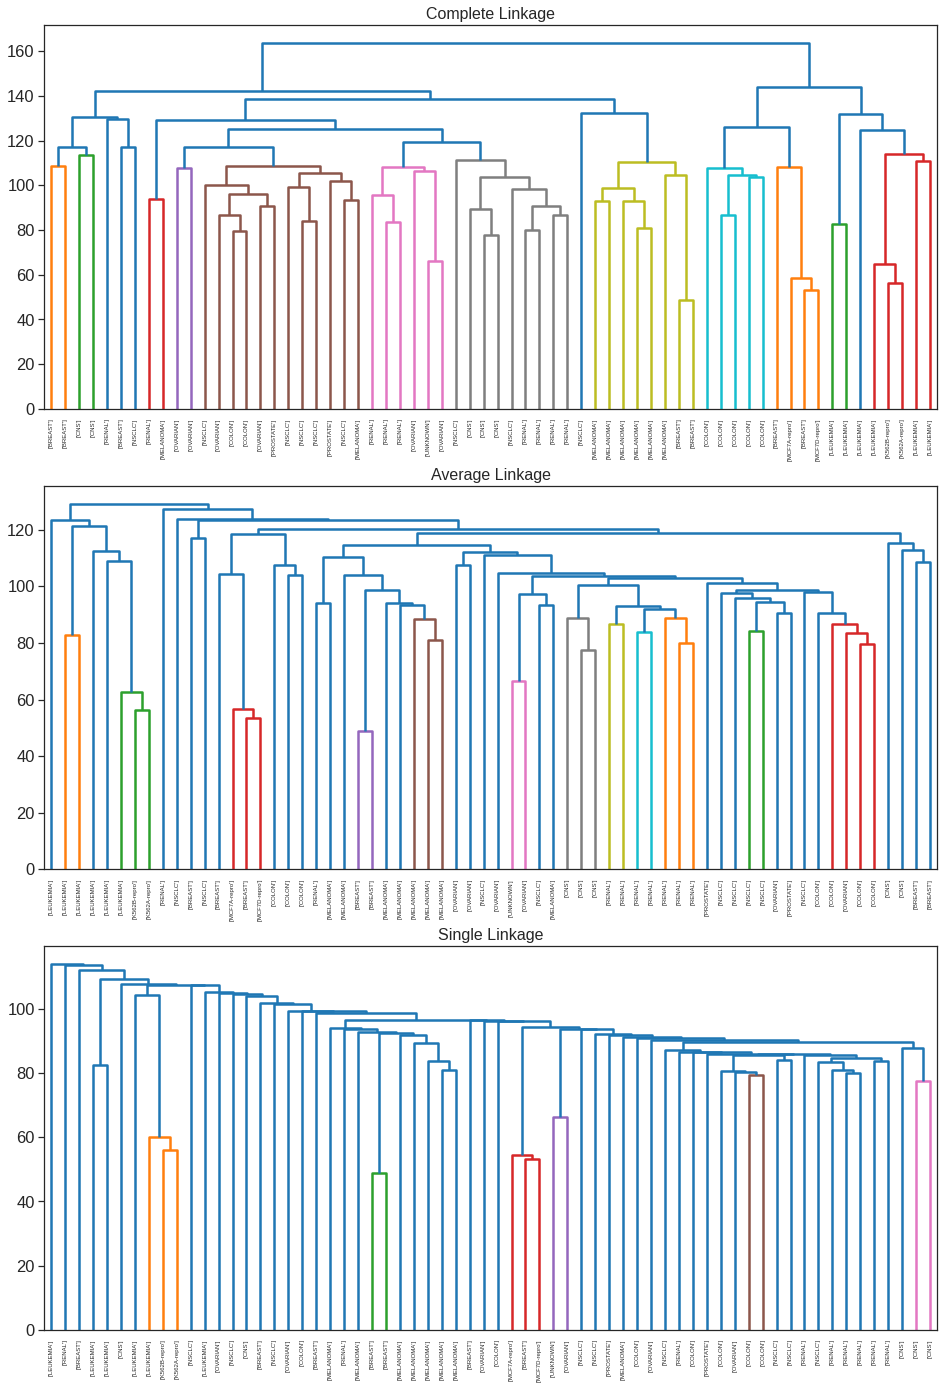

In [96]:
f, axes = plt.subplots(3, 1, sharex=False, sharey=False)

f.set_figheight(24)
f.set_figwidth(16)

dendrogram(linkage(NCI60_scaled, method='complete'),
           labels=NCI60_labs.values,
           leaf_rotation=90,
           leaf_font_size=6,
           ax=axes[0])

dendrogram(linkage(NCI60_scaled, method='average'),
           labels=NCI60_labs.values,
           leaf_rotation=90,
           leaf_font_size=6,
           ax=axes[1])

dendrogram(linkage(NCI60_scaled, method='single'),
           labels=NCI60_labs.values,
           leaf_rotation=90,
           leaf_font_size=6,
           ax=axes[2])

axes[0].set_title('Complete Linkage', size=16)
axes[1].set_title('Average Linkage', size=16)
axes[2].set_title('Single Linkage', size=16)

We see that the choice of linkage certainly does affect the results obtained. Typically, single linkage will tend to yield *trailing* clusters: very large clusters onto which  individual observations attach  one-by-one. On the other hand, complete and average linkage tend to yield more balanced, attractive clusters. For this reason, complete and average linkage are generally preferred to single linkage. Clearly cell lines within a single cancer type do tend to cluster together, although the clustering is not perfect. We will use complete linkage hierarchical clustering for the analysis that follows.

We can cut the dendrogram at the height that will yield a particular number of clusters, say four:

In [97]:
cut_tree(linkage(NCI60_scaled, method='complete'), 4).ravel()

array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 0,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

We can plot the cut on the dendrogram that produces these four clusters:

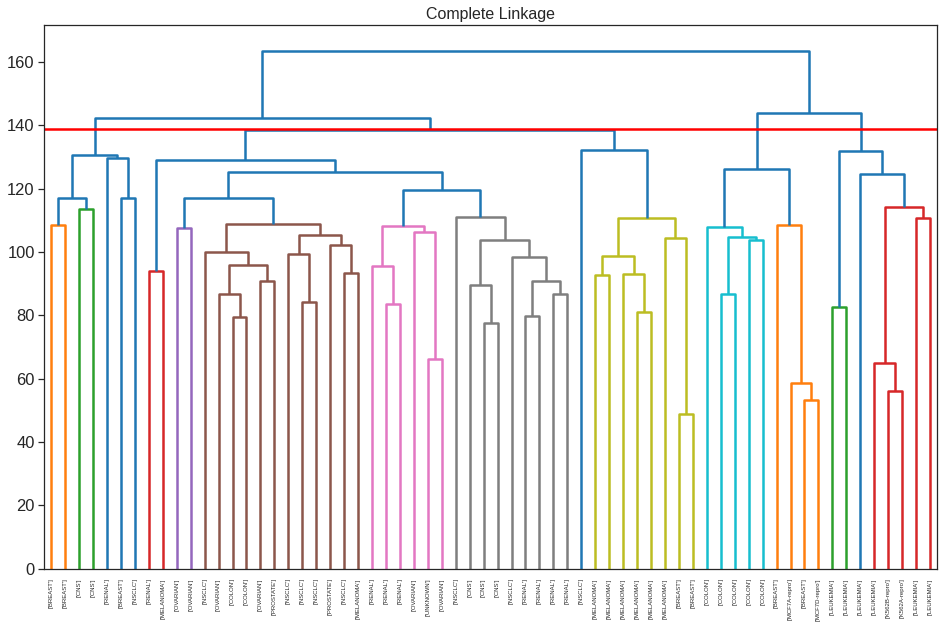

In [98]:
plt.figure(figsize=(16, 10))

dendrogram(linkage(NCI60_scaled, method='complete'),
           labels=NCI60_labs.values,
           leaf_rotation=90,
           leaf_font_size=6)

plt.axhline(y=139, c='r')
plt.title('Complete Linkage', size=16);

We claimed earlier in Section 12.4.2 that $K$-means clustering and hierarchical clustering with the dendrogram cut to obtain the same number of clusters can yield very different results.
How do these `NCI` hierarchical clustering results compare to what we  get if we perform $K$-means clustering with $K=4$?

In [99]:
kmeans = KMeans(n_clusters=4, n_init=20, random_state=0)
kmeans.fit(NCI60_scaled)
pd.crosstab(kmeans.labels_, cut_tree(linkage(NCI60_scaled, method='complete'), 4).ravel())

col_0,0,1,2,3
row_0,,,,
0,28,7,0,0
1,3,0,0,9
2,9,0,0,0
3,0,0,8,0


We see that the four clusters obtained using hierarchical clustering and $K$-means clustering  are somewhat different. Cluster $4$ in $K$-means clustering is identical to cluster $3$
in hierarchical clustering. However, the other clusters differ

Rather than performing hierarchical clustering on the entire data matrix, we can simply perform hierarchical clustering on the first few principal component score vectors,
as follows:

Text(0.5, 1.0, 'Hierarchical CLustering on First Five Score Vectors')

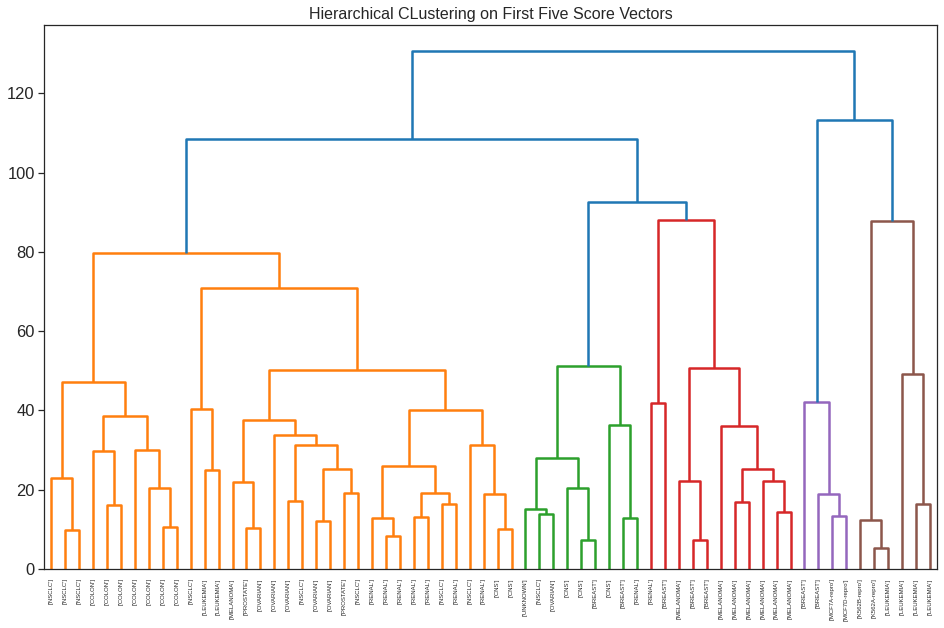

In [100]:
hc2 = linkage(X_reduced[:, 0:5], method='complete')

plt.figure(figsize=(16, 10))

dendrogram(hc2,
           labels=NCI60_labs.values,
           leaf_rotation=90,
           leaf_font_size=6)

plt.title('Hierarchical CLustering on First Five Score Vectors', size=16)

 Not surprisingly, these results are different from the ones that we  obtained when we performed hierarchical clustering on the full data
 set. Sometimes performing clustering on the first few principal  component score vectors can give better results than performing
 clustering on the full data.  In this situation, we might view the principal component step as one of denoising the data.
We could also perform $K$-means  clustering on the first few principal component score vectors rather  than the full data set.